## Data Loading

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
telemetry = pd.read_csv('./telemetry_cleaned.csv')
X = telemetry[['Easting', 'Northing', 'WaterDepth']].head(10000)
X.head(5)

,Easting,Northing,WaterDepth
0,0.158187,0.410159,92.93
1,0.158187,0.410159,5.86
2,0.534407,0.535898,5.86
3,0.534311,0.535924,6.33
4,0.533734,0.536254,7.02


### Raw Plot

In [3]:
def plot2d(data):
	data.plot(kind='scatter', x='Easting', y='Northing', color='#1F77B4')

def plot3d(data, title):
	fig = plt.figure()
	ax = fig.add_subplot(projection='3d')
	ax.scatter(data['Easting'], data['Northing'], data['WaterDepth'])
	ax.set_xlabel('Easting')
	ax.set_ylabel('Northing')
	ax.set_label
	ax.set_zlabel('WaterDepth')
	ax.set_title(title)
	plt.show()

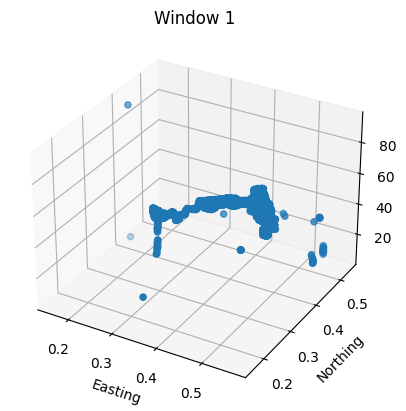

In [4]:
plot3d(X, 'Window 1')

### Grid Search

In [5]:
def grid_search_dbscan(data, options, verbose=False):
	results = []

	# Iterate through all combinations of options
	# And perform a DBSCAN evaluation on each
	option_combs = itertools.product(*options.values())

	for eps, min_samples in list(option_combs):
		if verbose: print(f'Running eps={eps}, min_samples={min_samples}')

		db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
		labels = db.labels_

		# Get estimated number of clusters and noise points
		clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
		noise = list(labels).count(-1)

		# Silhouette Coefficient
		silhouette = metrics.silhouette_score(X, labels)

		# Davies-Bouldin Score
		davies_bouldin = metrics.davies_bouldin_score(X, labels)

		if verbose: print(f'Finished with silhouette={silhouette}, davies={davies_bouldin}')

		results.append({
			'eps': eps,
			'min_samples': min_samples,
			'clusters': clusters,
			'noise': noise,
			'silhouette': silhouette,
			'davies_bouldin': davies_bouldin
		})

	return pd.DataFrame(results)

In [6]:
# Run grid search with the following options
options = {
	"eps": [0.1, 0.2, 0.3],
	"min_samples": [5, 7, 11, 13, 15]
}

results = grid_search_dbscan(X, options, True)

Running eps=0.1, min_samples=5
Finished with silhouette=0.5701055585086346, davies=1.5079628278467483
Running eps=0.1, min_samples=7
Finished with silhouette=0.6022754363136475, davies=1.8891777565713148
Running eps=0.1, min_samples=11
Finished with silhouette=0.6022185459442788, davies=4.895032227290086
Running eps=0.1, min_samples=13
Finished with silhouette=0.5976489557836661, davies=11.30432828180355
Running eps=0.1, min_samples=15
Finished with silhouette=0.43175475270026337, davies=7.063285794689473
Running eps=0.2, min_samples=5
Finished with silhouette=0.4433871233158374, davies=0.6732695291501817
Running eps=0.2, min_samples=7
Finished with silhouette=0.462649356123459, davies=0.8743153409795126
Running eps=0.2, min_samples=11
Finished with silhouette=0.4923503296854735, davies=0.8928465110643286
Running eps=0.2, min_samples=13
Finished with silhouette=0.7089429628648815, davies=0.9865290181920289
Running eps=0.2, min_samples=15
Finished with silhouette=0.7149395383063732, dav

In [7]:
results

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.1,5,21,167,0.570106,1.507963
1,0.1,7,20,227,0.602275,1.889178
2,0.1,11,19,328,0.602219,4.895032
3,0.1,13,18,384,0.597649,11.304328
4,0.1,15,15,468,0.431755,7.063286
5,0.2,5,6,92,0.443387,0.673270
6,0.2,7,4,108,0.462649,0.874315
7,0.2,11,7,109,0.492350,0.892847
8,0.2,13,9,126,0.708943,0.986529
9,0.2,15,9,142,0.714940,1.163269


Row with best silhouette score

In [41]:
best_silh = results.sort_values(by='silhouette', ascending=False, ignore_index=True).head(5)
best_silh

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.2,15,9,142,0.714940,1.163269
1,0.2,13,9,126,0.708943,0.986529
2,0.1,7,20,227,0.602275,1.889178
3,0.1,11,19,328,0.602219,4.895032
4,0.1,13,18,384,0.597649,11.304328


Row with best davies-bouldin score

In [30]:
best_davies = results.sort_values(by='davies_bouldin', ascending=True, ignore_index=True).head(5)
best_davies

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.3,5,5,78,0.454703,0.496186
1,0.3,7,4,90,0.465282,0.633599
2,0.2,5,6,92,0.443387,0.673270
3,0.3,11,4,93,0.464202,0.676460
4,0.3,13,4,96,0.463941,0.703803


### Visualise

In [13]:
def plot_clusters(db, title, show_noise=True):
	unique_labels = set(db.labels_)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True

	colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

	for k, color in zip(unique_labels, colors):
		if k == -1 and not show_noise:
			# Black used for noise
			color = [0, 0, 0, 1]
			continue

		class_member_mask = db.labels_ == k

		core_samples = X[class_member_mask & core_samples_mask]

		plt.plot(
			core_samples['Easting'],
			core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=10,
		)

		non_core_samples = X[class_member_mask & ~core_samples_mask]
		plt.plot(
			non_core_samples['Easting'],
			non_core_samples['Northing'],
			"o",
			markerfacecolor=tuple(color),
			markeredgecolor='k',
			markersize=3,
		)

	plt.title(f'{title} Clusters: {len(unique_labels)-1}, Noise: {list(db.labels_).count(-1)}')
	plt.show()

In [14]:
db = DBSCAN(eps=0.2, min_samples=13).fit(X)

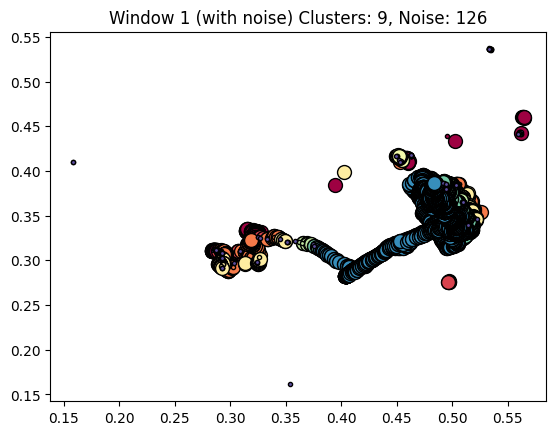

In [19]:
plot_clusters(db, 'Window 1 (with noise)')

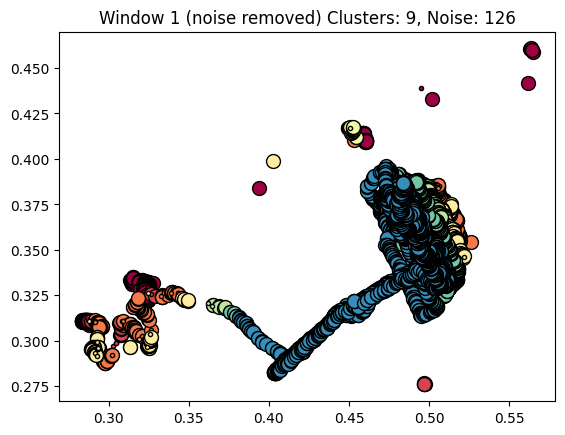

In [17]:
plot_clusters(db, 'Window 1 (noise removed)', False)

### Fine-tuning

In [32]:
# Run grid search with the following options
options_ft = {
	"eps": [0.19, 0.2, 0.21],
	"min_samples": [12, 13, 14]
}

results_ft = grid_search_dbscan(X, options_ft, True)

Running eps=0.19, min_samples=12
Finished with silhouette=0.5109505916720622, davies=1.1020650688931917
Running eps=0.19, min_samples=13
Finished with silhouette=0.7181031436768913, davies=1.214041249990363
Running eps=0.19, min_samples=14
Finished with silhouette=0.7174544054426563, davies=1.2386827394054514
Running eps=0.2, min_samples=12
Finished with silhouette=0.5250036851969186, davies=0.9251837738491291
Running eps=0.2, min_samples=13
Finished with silhouette=0.7089429628648815, davies=0.9865290181920289
Running eps=0.2, min_samples=14
Finished with silhouette=0.7191176114880448, davies=1.1488783777294822
Running eps=0.21, min_samples=12
Finished with silhouette=0.5229030362037271, davies=0.8539023021486871
Running eps=0.21, min_samples=13
Finished with silhouette=0.7218712659638079, davies=0.8274044415547801
Running eps=0.21, min_samples=14
Finished with silhouette=0.711448689280707, davies=0.8812000181147732


In [42]:
results_ft

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.19,12,8,135,0.510951,1.102065
1,0.19,13,8,151,0.718103,1.214041
2,0.19,14,9,154,0.717454,1.238683
3,0.20,12,7,115,0.525004,0.925184
4,0.20,13,9,126,0.708943,0.986529
5,0.20,14,8,141,0.719118,1.148878
6,0.21,12,5,108,0.522903,0.853902
7,0.21,13,8,109,0.721871,0.827404
8,0.21,14,9,116,0.711449,0.881200


In [43]:
best_silh_ft = results_ft.sort_values(by='silhouette', ascending=False, ignore_index=True).head(5)
best_silh_ft

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.21,13,8,109,0.721871,0.827404
1,0.20,14,8,141,0.719118,1.148878
2,0.19,13,8,151,0.718103,1.214041
3,0.19,14,9,154,0.717454,1.238683
4,0.21,14,9,116,0.711449,0.881200


In [44]:
best_davies_ft = results_ft.sort_values(by='davies_bouldin', ascending=True, ignore_index=True).head(5)
best_davies_ft

,eps,min_samples,clusters,noise,silhouette,davies_bouldin
0,0.21,13,8,109,0.721871,0.827404
1,0.21,12,5,108,0.522903,0.853902
2,0.21,14,9,116,0.711449,0.881200
3,0.20,12,7,115,0.525004,0.925184
4,0.20,13,9,126,0.708943,0.986529


In [56]:
print('Silhouette', best_silh['silhouette'][1], 'Davies-Bouldin', best_silh['davies_bouldin'][1])
print(f"Silhouette i: {best_silh_ft['silhouette'][0] - best_silh['silhouette'][1]}")
print(f"Davies-Bouldin i: {best_silh_ft['davies_bouldin'][0] - best_silh['davies_bouldin'][1]}")

Silhouette 0.7089429628648815 Davies-Bouldin 0.9865290181920289
Silhouette i: 0.012928303098926452
Davies-Bouldin i: -0.15912457663724877
